# [Project 1] 노래 인기도 데이터 군집 분석

---

## 프로젝트 목표
- 노래별 속성 정보와 인기도를 기록한 데이터를 통해 군집 분석을 수행
- 비지도 학습의 또 다른 대표적인 기법인 차원 축소를 통해 데이터 시각화

---

## 프로젝트 목차
1. **데이터 읽기:** 노래 인기도 데이터를 이루고 있는 요소에 대해서 Dataframe를 사용하여 분석 및 확인

2. **데이터 정제:** 데이터에 존재하는 결측치 확인

3. **데이터 시각화:** 데이터를 이루는 변수들 값의 분포를 시각화

4. **군집 모델 - K-Means:** 군집 모델의 대표 모델인 K-Means를 적용하고 결과 확인

5. **차원 축소**: 데이터의 차원을 축소하기 위한 기법들을 적용하고 결과 확인

---

## 데이터 출처
-  https://www.kaggle.com/datasets/yasserh/song-popularity-dataset

---

## 프로젝트 개요

인기 있는 노래와 인기가 상대적으로 적은 노래에는 어떤 차이가 있을까요? 보통은 해당 노래가 나왔던 시대적 배경, 해당 노래를 발표한 가수나 그룹에 기대하는 바, 주요 팬층, 장르 등의 문화적 요소가 인기를 결정한다고 생각하기 쉬울 것입니다.

물론 전반적으로는 그런 요소가 인기 요인의 대부분이겠지만, 혹시 곡 자체가 가지고 있는 어떤 물리적인 특성이 비슷한 곡들은 인기도도 비슷한 경향을 보이지 않을까요? 다른 말로 하면 곡의 시끄러움 정도, 전자음의 사용 정도, 곡이 전반적으로 가지는 에너지, 음정 등의 요소가 비슷하면 받는 인기도도 비슷하게 될까요?

이번 프로젝트에서는 이러한 요소를 수치로 정리한 데이터에 군집 모델(Clustering)과 차원 축소(Dimensionality Reduction) 기법을 적용하여 곡의 여러 특성들이 비슷한 것끼리 묶어보고 분석해보는 프로젝트를 수행해 보겠습니다.

이번 프로젝트를 통하여 회귀나 분류 같이 별도의 예측 목표가 명시적으로 주어지지 않은 상황에서도 기계 학습 모델을 통해 어떻게 데이터를 유의미하게 분석할 수 있는지 학습할 수 있습니다.
 

---

In [2]:
# 프로젝트에서 사용할 라이브러리들을 불러옵니다.
!pip install umap-learn==0.5.3
!pip install -U seaborn==0.11.2
!pip install -U scikit-learn==1.1.2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from umap import UMAP

SEED = 2022

     |████████████████████████████████| 88 kB 7.5 MB/s  eta 0:00:01
     |████████████████████████████████| 1.1 MB 108.8 MB/s eta 0:00:01
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82820 sha256=56fdae8e3fe45427ecc74272216a424a22088e2ccb34369ab1d3f91f8a79eb6d
  Stored in directory: /home/jovyan/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55623 sha256=cf029d446cddd05c4d8de7e4b54d89399d087a997b3113249059ceacabdd79bb
  Stored in directory: /home/jovyan/.cache/pip/wheels/f8/32/54/fa1fd0454e0441eaa32550ea2a86da3f64eb7c8e5a82436770
Successfully built umap-learn pynndescent
You should consider upgrading via the '/opt/conda/bin/python3.8 -m pip install --upgrade pip' command.
     |████████████████████████████████| 292 kB 17.2 MB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.1
    Uninstalling seab

## 1. 데이터 읽기

본 프로젝트에서 사용할 `song_data.csv` 파일을 읽고 DataFrame 형태로 저장합니다.

In [3]:
df_origin = pd.read_csv("./song_data.csv")
df_origin

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18830,Let It Breathe,60,159645,0.893000,0.500,0.151,0.000065,11,0.1110,-16.107,1,0.0348,113.969,4,0.300
18831,Answers,60,205666,0.765000,0.495,0.161,0.000001,11,0.1050,-14.078,0,0.0301,94.286,4,0.265
18832,Sudden Love (Acoustic),23,182211,0.847000,0.719,0.325,0.000000,0,0.1250,-12.222,1,0.0355,130.534,4,0.286
18833,Gentle on My Mind,55,352280,0.945000,0.488,0.326,0.015700,3,0.1190,-12.020,1,0.0328,106.063,4,0.323


일단 머신 러닝 모델에 적용하기 위해 문자열로 이루어진 `song_name` 컬럼은 제거합니다.

이외의 컬럼들은 이름을 통해 의미 파악이 가능하므로 자세한 내용은 여기서 생략하고 데이터셋 제공 링크를 참고해주시길 바랍니다.

In [4]:
df = df_origin.drop("song_name", axis=1)
df.shape

(18835, 14)

In [5]:
# dataframe의 정보를 요약해서 출력합니다.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_popularity   18835 non-null  int64  
 1   song_duration_ms  18835 non-null  int64  
 2   acousticness      18835 non-null  float64
 3   danceability      18835 non-null  float64
 4   energy            18835 non-null  float64
 5   instrumentalness  18835 non-null  float64
 6   key               18835 non-null  int64  
 7   liveness          18835 non-null  float64
 8   loudness          18835 non-null  float64
 9   audio_mode        18835 non-null  int64  
 10  speechiness       18835 non-null  float64
 11  tempo             18835 non-null  float64
 12  time_signature    18835 non-null  int64  
 13  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5)
memory usage: 2.0 MB


In [6]:
# 수치형 변수의 통계량 정보를 출력합니다.
df.describe()

,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
count,18835.000000,1.883500e+04,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000,18835.000000
mean,52.991877,2.182116e+05,0.258539,0.633348,0.644995,0.078008,5.289196,0.179650,-7.447435,0.628139,0.102099,121.073154,3.959119,0.527967
std,21.905654,5.988754e+04,0.288719,0.156723,0.214101,0.221591,3.614595,0.143984,3.827831,0.483314,0.104378,28.714456,0.298533,0.244632
min,0.000000,1.200000e+04,0.000001,0.000000,0.001070,0.000000,0.000000,0.010900,-38.768000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,1.843395e+05,0.024100,0.533000,0.510000,0.000000,2.000000,0.092900,-9.044000,0.000000,0.037800,98.368000,4.000000,0.335000
50%,56.000000,2.113060e+05,0.132000,0.645000,0.674000,0.000011,5.000000,0.122000,-6.555000,1.000000,0.055500,120.013000,4.000000,0.527000
75%,69.000000,2.428440e+05,0.424000,0.748000,0.815000,0.002570,8.000000,0.221000,-4.908000,1.000000,0.119000,139.931000,4.000000,0.725000
max,100.000000,1.799346e+06,0.996000,0.987000,0.999000,0.997000,11.000000,0.986000,1.585000,1.000000,0.941000,242.318000,5.000000,0.984000


## 2. 데이터 정제

데이터 정제에서는 **결측값(missing value)** 또는 **이상치(outlier)** 를 처리합니다.

결측값의 경우 너무 많으면 결측값이 존재하는 row를 직접 제거하기도 하고, 적은 편이면 통계적 기법을 통해 대체하기도 합니다.

이상치의 경우 본 데이터의 각 수치형 변수들은 명확한 상한값과 하한값을 가지고 수집된 것으로 보입니다. 즉 데이터셋을 만드는 과정에서 이미 이상치의 고려가 이루어진 것이기 때문에 별도로 처리하지는 않겠습니다.

먼저 전체 데이터에서 결측값 개수가 몇개 있는지 확인합니다.

In [7]:
# 결측값 개수를 출력합니다.
df.isnull().sum()

song_popularity     0
song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
dtype: int64

모든 컬럼에서 결측치가 존재하지 않습니다. 따라서 결측치 처리는 추가로 진행하지 않겠습니다.

실제 현업에서 사용하는 데이터의 경우 이와 같은 상황은 굉장히 드문 경우라는 점 참고 바랍니다.

## 3. 데이터 시각화

데이터에 포함된 각 변수의 분포를 하나씩 확인해봅니다.

### 3.1. `song_popularity` 시각화

곡의 인기도를 0 ~ 100 사이로 수치화한 `song_popularity`를 확인해봅니다. (100일수록 높은 인기)

<AxesSubplot:xlabel='song_popularity', ylabel='Percent'>

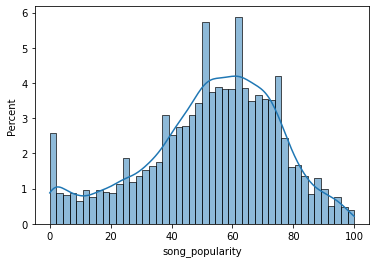

In [8]:
sns.histplot(df, x="song_popularity", kde=True, stat="percent")

전반적으로 50 ~ 75 사이 정도의 수치가 가장 많은 비중을 차지하는 것을 알 수 있습니다.

### 3.2. `acousticness` 시각화

곡에 전자음을 얼마나 사용하지 않았는지의 정도를 수치화한 `acousticness`를 확인해봅니다. (1일수록 전자음이 배제됨)

<AxesSubplot:xlabel='acousticness', ylabel='Percent'>

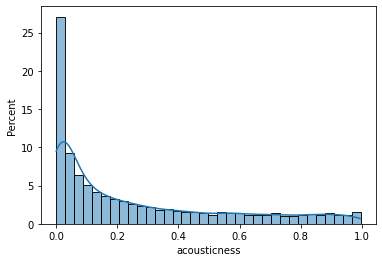

In [9]:
sns.histplot(df, x="acousticness", kde=True, stat="percent")

상당히 높은 비중의 음악들이 전자음을 많이 사용한 것을 알 수 있습니다.

바로 상관관계를 판단하기엔 조심스럽지만 많은 곡의 인기도가 50 ~ 75임을 감안하면 대중적으로 적절히 인기를 끄는 음악들은 전자음의 사용이 많은 것이 아닐까라고 추측해볼 수 있습니다.

### 3.3. `danceability` 시각화

곡이 얼마나 춤추는 데 적합한지를 수치화한 `danceability`를 확인해봅니다. (1일수록 춤추기에 적합함)

<AxesSubplot:xlabel='danceability', ylabel='Percent'>

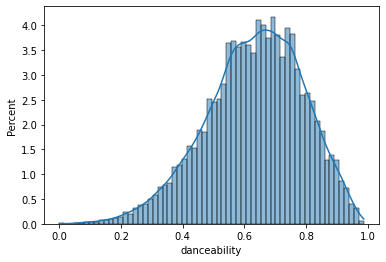

In [10]:
sns.histplot(df, x="danceability", kde=True, stat="percent")

인기도와 비슷하게 0.5 ~ 0.8 사이의 수치가 대부분임을 확인할 수 있습니다.

### 3.4. `energy` 시각화

곡이 얼마나 에너지가 넘치는지를 수치화한 `energy`를 확인해봅니다. (1일수록 에너지가 넘침)

<AxesSubplot:xlabel='energy', ylabel='Percent'>

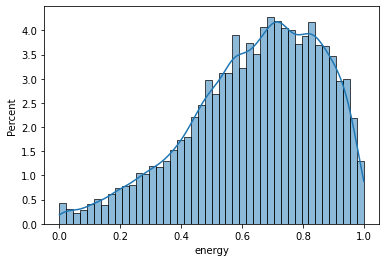

In [11]:
sns.histplot(df, x="energy", kde=True, stat="percent")

역시 인기도와 danceability와 비슷하게 0.5 이상의 수치가 많은데, 미묘하게 1에 가까운 비중이 좀 더 높은 것을 확인할 수 있습니다.

### 3.5. `key` 시각화

곡의 조(調)를 나타내는 `key`를 확인해봅니다.

<AxesSubplot:xlabel='key', ylabel='Percent'>

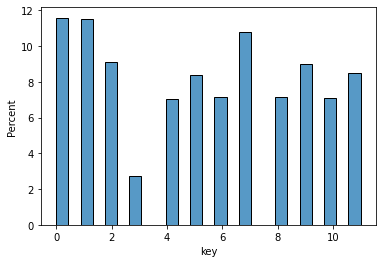

In [12]:
sns.histplot(df, x="key", kde=False, stat="percent")

### 3.6. `tempo` 시각화

곡의 빠르기(BPM)를 나타내는 `tempo`를 확인해봅니다.

<AxesSubplot:xlabel='tempo', ylabel='Percent'>

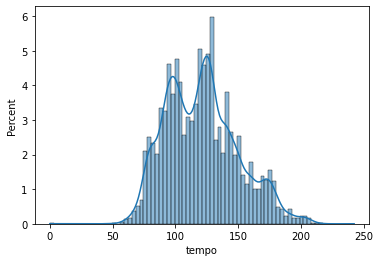

In [13]:
sns.histplot(df, x="tempo", kde=True, stat="percent")

## 4. 군집 모델 - K-Means

비슷한 성질을 가지는 곡들을 자동으로 묶어보기 위해 군집 모델의 가장 대표 모델인 **K-Means** 모델을 적용해보겠습니다.

K-Means 모델은 전체 데이터에서 각 군집(cluster)의 중심점(centroid)이 될 지점을 K개 선정해서 임의로 초기화합니다. (이 초기화 과정도 여러 알고리즘이 있지만 여기서는 가장 간단하게 임의 초기화로 한정하겠습니다.) 여기서 K개가 곧 클러스터의 개수가 됩니다.

이후 각 중심점과 가장 가까운 데이터들을 모아서 군집들을 형성합니다. **가까움**의 기준은 보통 유클리드 거리(Euclidean Distance)로 판단하지만 이 역시 다양한 metric이 존재합니다. 본론으로 돌아와서, 이렇게 새로 형성된 군집들에서 새로 중심점을 구합니다. 이후 중심점의 위치가 더이상 변하지 않을 때까지 이 과정을 반복합니다.

<center><img src="img/kmeans.png"></center>

즉 요약하면,
1. 임의로 K개 중심점 초기화
2. 각 중심점과 가장 가까운 데이터로 새로운 군집 형성
3. 각 군집에서 새롭게 중심점 지정
4. 중심점 위치가 변하지 않을 때까지 1-3 과정 반복

여기서 알 수 있는 사실은 K-Means 모델의 가장 중요한 하이퍼파라미터는 군집의 개수인 **K** 라는 것입니다. 이 값을 어떻게 설정하냐에 따라 군집 분석 결과가 크게 달라질 수 있을 것입니다.

따라서 본 프로젝트에서는 사전에 다양한 K값을 확인해본 결과 **4개**가 가장 적절해보이는 개수였기 때문에 `K=4`로 두겠습니다. 분석 과정을 모두 확인한 후에 궁금하신 분들은 K값을 변경시켰을 때 결과가 어떻게 달라지는지 확인해보는 것도 좋을 것입니다.

### 4.1. K-Means로 군집 분석 수행

진행하기에 앞서 주어진 데이터에 **표준화**를 적용하여 정규화를 수행하겠습니다.

In [14]:
scaler = StandardScaler()
X = scaler.fit_transform(df)

이제 정규화된 데이터에 K-Means 모델을 적용합니다. 클러스터 개수를 4개로 지정한 것에 유의하세요.

In [15]:
kmeans = KMeans(n_clusters=4, random_state=SEED).fit(X)

과연 각 데이터는 어떤 클러스터에 배정되었을까요? 이를 확인하기 위해 `predict` 메소드를 사용합니다.

In [16]:
y_pred = kmeans.predict(X)
print(f"클러스터 라벨 개수: {y_pred.shape}")
print(f"10개 라벨 미리보기: {y_pred[:10]}")

클러스터 라벨 개수: (18835,)
10개 라벨 미리보기: [1 3 1 1 1 3 3 1 1 1]


이제 확인해볼 것은 각 클러스터 라벨 별로 묶어서 곡 데이터를 이루던 각 변수의 분포가 어떻게 되는지입니다.

즉 라벨 별로 3장에서 확인했던 각 변수 분포가 어떤지를 한번에 확인해보도록 하겠습니다. 간결함을 위해 사전 확인 결과 의미가 있었던 변수만 확인하겠습니다.

### 4.2. 클러스터별 `song_popularity` 분포

먼저 본 데이터의 가장 대표적인 변수인 `song_popularity`가 클러스터별로 어떻게 나뉘었는지 확인해보겠습니다.

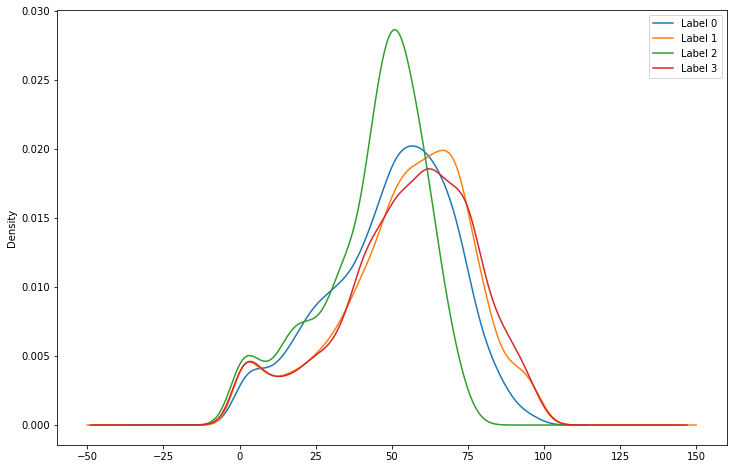

In [17]:
# 클러스터 라벨별 song_popularity 분포 확인
fig = plt.figure(figsize=(12, 8))
ax = plt.gca()

for i in set(y_pred):
    df[y_pred == i]["song_popularity"].plot(kind="kde", ax=ax, label=f"Label {i}")

plt.legend()
plt.show()

곡 인기도의 분포는 두 클러스터가 다른 두 클러스터보다 미묘하게 인기가 높은 것을 알 수 있습니다. 과연 이 클러스터들의 다른 특징은 어떨까요?

### 4.3. 클러스터별 `acousticness` 분포

`acousticness`가 클러스터별로 어떻게 나뉘었는지 확인해보겠습니다.

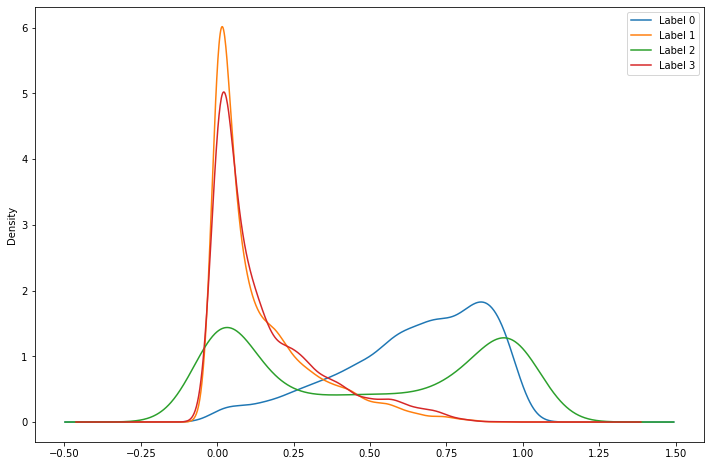

In [18]:
# 클러스터 라벨별 acousticness의 분포 확인
fig = plt.figure(figsize=(12, 8))
ax = plt.gca()

for i in set(y_pred):
    df[y_pred == i]["acousticness"].plot(kind="kde", ax=ax, label=f"Label {i}")

plt.legend()

확인해보니 앞서 인기도가 높았던 클러스터들은 `acousticness`가 낮은 쪽에 높은 분포를 가지고 있지만 인기도가 미묘하게 낮았던 클러스터들은 전반적으로 높은 `acousticness`를 가지는 것을 알 수 있습니다.

아직 두 변수만 확인해봤지만, 전반적으로 전자음이 가득한 음악과 그렇지 않은 음악들로 클러스터가 나뉘어진 것 같습니다.

### 4.4. 클러스터별 `energy` 분포

`energy`가 클러스터별로 어떻게 나뉘었는지 확인해보겠습니다.

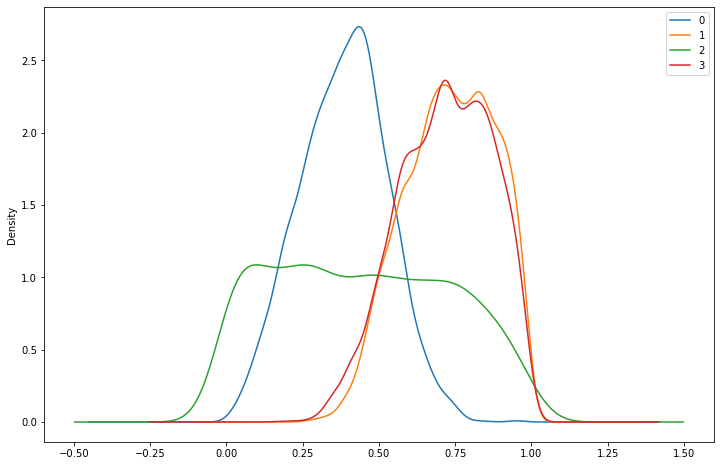

In [19]:
fig = plt.figure(figsize=(12, 8))
ax = plt.gca()

for i in set(y_pred):
    df[y_pred == i]["energy"].plot(kind="kde", ax=ax, label=f"{i}")

plt.legend()

여기서는 좀 더 흥미로운 결과가 나오고 있습니다. 확실히 앞서 전자음이 많은 곡들이 모인 것으로 추정된 클러스터는 높은 에너지 수치를 가집니다만, 그렇지 않았던 두 클러스터의 양상이 달라졌습니다.

한 클러스터는 전반적으로 낮은 에너지 수치를 가진 곡들만 있지만, 다른 클러스터는 에너지 수치가 꽤 고르게 분포되어 있습니다. 과연 다른 변수는 어떤 양상을 보일까요?

### 4.5. 클러스터별 `key` 분포

`key`가 클러스터별로 어떻게 나뉘었는지 확인해보겠습니다.

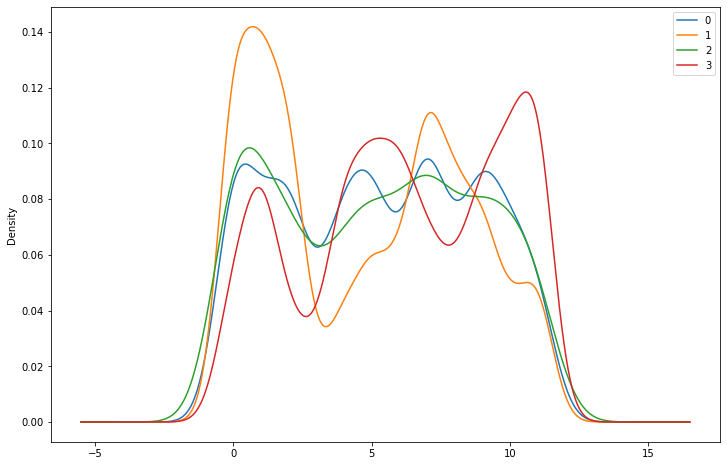

In [20]:
fig = plt.figure(figsize=(12, 8))
ax = plt.gca()

for i in set(y_pred):
    df[y_pred == i]["key"].plot(kind="kde", ax=ax, label=f"{i}")

plt.legend()

앞서 전자음 비중이 낮았던 두 클러스터는 `energy` 분포가 다소 달랐던 것을 확인할 수 있었습니다.

그래서 이번엔 전자음 비중이 높았던 두 클러스터를 비교해보고자 `key` 변수를 확인해봤습니다.

여기서는 미묘하지만 전반적으로 한 클러스터가 다른 클러스터에 비해 조 위치가 좀더 높은 곳에 분포한 것을 알 수 있습니다.

### 4.6. 클러스터별 실제 음악 확인

마지막으로 각 클러스터에 어떤 음악들이 실제로 들어있는지 이름을 확인해보겠습니다. 현실적으로 모두 확인하기는 어려우니 몇개만 예시로 확인합니다.

In [21]:
for i in set(y_pred):
    print("=" * 25, f"[Label {i}]", "=" * 25)
    print(df_origin[y_pred == i]["song_name"].sample(n=5))
    print()

========================= [Label 0] =========================
378                    Walkin' Back to Georgia
6907     Ain't That A Shame? - Remastered 2002
1283                           Secreto De Amor
10535              A Letter to My Younger Self
16908                        Song That I Heard
Name: song_name, dtype: object

========================= [Label 1] =========================
3837                    Love Train
7663     Promises (with Sam Smith)
920                     Wonderwall
990                      Mr. Jones
10363               Amante Bandido
Name: song_name, dtype: object

========================= [Label 2] =========================
17503        Astroworld
11104            Meadow
10945         Easy Baby
13338         A New Day
2975     Autumn Sweater
Name: song_name, dtype: object

========================= [Label 3] =========================
14402               Perdóname
8915                    Tango
10309            Fruta Fresca
4253                Found You
13677 

## 5. 차원 축소

다음으로는 **차원 축소(Dimensionality Reduction)** 기법을 통한 시각화를 알아보겠습니다. 차원 축소는 쉽게 얘기해서 기존 데이터가 가지고 있는 변수의 개수를 줄이는 기법을 의미합니다.

차원 축소가 쓰이게 된 이유는 대표적으로 **차원의 저주(Curse of Dimensionality)** 문제를 완화하고자 함입니다. 차원의 저주 문제란 차원 개수, 즉 변수 개수가 많아질수록 기계학습 모델이 제대로 동작하기 위한 데이터의 개수가 기하급수적으로 늘어나는 것을 의미합니다.

<center><img src="img/curse_of_dimensionality.png" width=500px></center>

데이터 수는 적은데 차원만 많아지면 전체 공간에서 데이터가 차지하는 비중이 굉장히 희박해지고, 이는 머신러닝 모델이 데이터의 유의미한 패턴 파악을 어렵게 만듭니다. 따라서 데이터가 가지고 있는 정보를 최대한 보존하면서 차원을 줄이는 기법이 바로 차원 축소 기법입니다.

차원 축소는 다양한 상황에서 사용할 수 있습니다. 비지도 학습의 일종이지만 분류나 회귀 모델을 학습할 때 데이터를 전처리 하기 위한 과정에서도 사용할 수 있고, 이 프로젝트에서처럼 시각화를 할 때도 사용할 수 있습니다. 물론 이 외에도 다양한 경우가 가능합니다.

여기서는 데이터 시각화를 위해 차원 축소 기법을 활용해 보겠습니다. 왜 시각화에 사용하냐고 하면 기존 데이터가 가지고 있는 변수가 14개(`song_name` 제외)였는데, 이는 3차원이 넘기 때문에 사람 눈으로 확인할 수가 없습니다. 따라서 데이터의 분포를 사람 눈으로 확인해보고자 데이터를 2차원 혹은 3차원으로 줄이기 위해 사용하는 것입니다.

### 5.1. 주성분 분석 (PCA)

**주성분 분석(Principal Component Analysis, PCA)** 은 가장 대표적인 차원 축소 기법입니다. PCA는 줄였을 때의 차원 개수를 자유롭게 설정할 수 있으므로 시각화 뿐만 아니라 다양한 상황에 응용할 수 있습니다. 여기서는 시각화를 위해 2차원으로 줄이는 PCA를 적용해보겠습니다.

PCA의 간단한 동작 원리는 주어진 원본 데이터의 정보를 최대한 보존할 수 있는 새로운 차원 축을 찾는 것입니다. 이 축을 주성분(Principal Component)라고 부르며, 이를 찾는 원리는 **데이터의 분산(variance)이 가장 커지는 축**을 찾는 것입니다.

<center><img src="img/pca.png" width=500px></center>

말로 하면 잘 와닿지 않은데, 위 그림을 보면 첫번째 주성분을 새로운 축이라고 했을 때, 데이터들이 해당 축 상의 값을 봤을 때 넓은 범위에 분포한 것을 알 수 있습니다. 이게 분산이 가장 커지는 축을 찾은 결과라고 할 수 있습니다. 그리고 이때 분산값을 **Explained Varaince** 라고 하며, 보통은 각 주성분 간의 분산값의 비율인 **Explained Variance Ratio**를 확인합니다.

PCA 또한 scikit-learn을 이용하면 굉장히 간단하게 사용할 수 있습니다.

In [22]:
# 시각화를 위해 2차원으로 축소합니다.
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X)
X_pca.shape

(18835, 2)

2차원으로 줄어든 것을 확인하였습니다. 이제 K-Means에서 구한 클러스터 라벨을 곁들여서 시각화를 해보겠습니다.

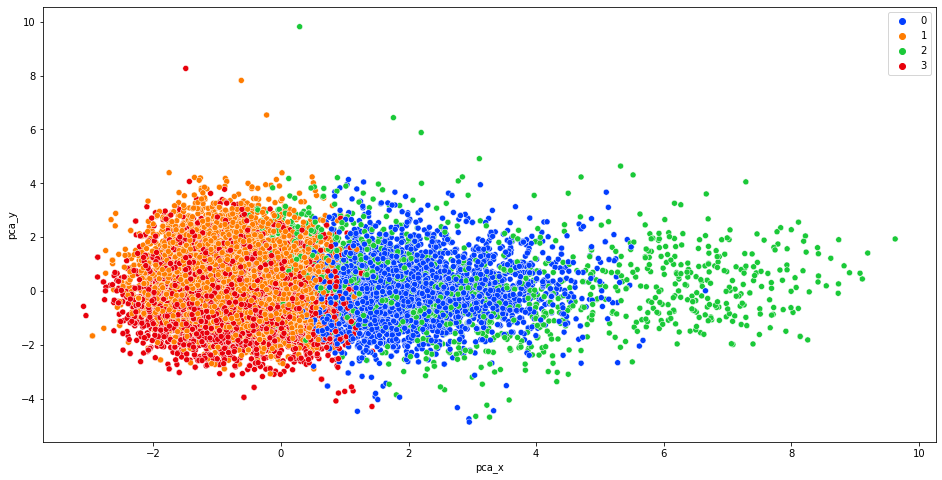

In [23]:
# 시각화를 위해 PCA 결과와 클러스터 라벨을 하나의 DataFrame으로 합칩니다.
pca_df = pd.DataFrame(
    np.concatenate([X_pca, y_pred[:, np.newaxis]], axis=1),
    columns=["pca_x", "pca_y", "Label"]
)
pca_df["Label"] = pca_df["Label"].astype(int)

# scatter plot으로 시각화합니다.
fig = plt.figure(figsize=(16, 8))
ax = plt.gca()
sns.scatterplot(data=pca_df, x="pca_x", y="pca_y", hue="Label", palette="bright", ax=ax)
plt.legend()

PCA를 통해 차원 축소된 데이터들이 K-Means가 찾아낸 라벨과 일맥상통하게 분포되어 있는 모습을 확인할 수 있습니다!

K-Means의 결과와 PCA의 결과가 항상 일치하지 않을 수 있기 때문에 이는 꽤 의미있는 결과라 할 수 있습니다.

## 5.2. t-SNE와 UMAP

다음으로 알아볼 차원 축소 기법들은 **시각화**를 염두에 두고 개발된 기법들입니다. 즉 PCA와는 다소 결이 다르다고 할 수 있고, 그렇기 때문에 이들은 항상 2차원 혹은 3차원으로 데이터를 줄이는 것을 목표로 합니다.

t-SNE와 UMAP의 개념은 굉장히 복잡한 편입니다. [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)는 t-distribution stochastic neighbor embedding의 약자로 확률 분포 중 t-분포를 활용한 차원 축소 기법입니다.

[UMAP](https://umap-learn.readthedocs.io/en/latest/)은 Uniform Manifold Approximation and Projection의 약자로, t-SNE보단 상대적으로 최신에 나온 기법입니다. 일반적으로는 t-SNE보다 좀 더 그럴듯한(?) 축소 결과를 내준다고 알려져 있습니다. 물론 항상 그렇지는 않다는 점 참고 바랍니다. 아무튼 비교적 최신에 나온 만큼 수학적 배경이 꽤 복잡한 편이라 논문 저자도 *이러이러한 수학적 배경이 필요하니 익숙하지 않으면 건너뛰세요* 라고 얘기할 정도입니다.

<center><img src="img/umap_paper.jpg"></center>

그래서 바로 라이브러리를 통해 사용해보도록 하겠습니다. t-SNE는 scikit-learn을 통해 사용 가능하고 UMAP은 `umap-learn`이라는 별도 패키지가 필요합니다.

In [24]:
# n_components와 random_state 외의 파라미터는 FuterWarning 때문에 지정한 옵션입니다.
# TSNE 모델 학습에 시간이 최대 2분 정도 소요될 수 있습니다.
tsne = TSNE(n_components=2, n_iter=250, learning_rate="auto", init="pca", random_state=SEED)
X_tsne = tsne.fit_transform(X)
X_tsne.shape

/opt/conda/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


(18835, 2)

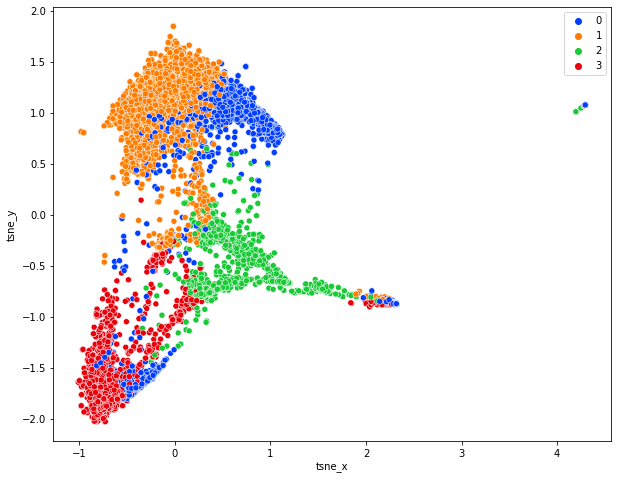

In [26]:
# 시각화를 위해 t-SNE 결과와 클러스터 라벨을 하나의 DataFrame으로 합칩니다.
tsne_df = pd.DataFrame(
    np.concatenate([X_tsne, y_pred[:, np.newaxis]], axis=1),
    columns=["tsne_x", "tsne_y", "Label"]
)
tsne_df["Label"] = tsne_df["Label"].astype(int)

# scatter plot으로 시각화합니다.
fig = plt.figure(figsize=(10, 8))
ax = plt.gca()
sns.scatterplot(data=tsne_df, x="tsne_x", y="tsne_y", hue="Label", palette="bright", ax=ax)
plt.legend()

어떤 것 같나요? 전자음 비중이 높았던 클러스터들은 좀더 확실히 분리가 된 듯한 모습을 가집니다. 그렇지 않은 클러스터도 분리가 된 것으로 보이는데, 하나가 분단된 모습을 보이는 형태를 하고 있습니다.

다음으로는 UMAP을 확인해보겠습니다.

In [27]:
umap = UMAP(random_state=SEED)
X_umap = umap.fit_transform(X)
X_umap.shape

(18835, 2)

In [ ]:
# 시각화를 위해 UMAP 결과와 클러스터 라벨을 하나의 DataFrame으로 합칩니다.
umap_df = pd.DataFrame(
    np.concatenate([X_umap, y_pred[:, np.newaxis]], axis=1),
    columns=["umap_x", "umap_y", "Label"]
)
umap_df["Label"] = umap_df["Label"].astype(int)

# scatter plot으로 시각화합니다.
fig = plt.figure(figsize=(10, 8))
ax = plt.gca()
sns.scatterplot(data=umap_df, x="umap_x", y="umap_y", hue="Label", palette="bright", ax=ax)
plt.legend()

T-SNE처럼 전자음 비중이 높았던 두 클러스터는 확실히 분리한 모습인데, 그렇지 않은 클러스터 중 하나가 여기저기 섬처럼 분포된 모습을 확인할 수 있습니다.

## 제출

지금까지 K-Means 모델과 대표적인 차원 축소 기법들을 알아보았습니다.

본 프로젝트에서는 K-Means를 원본 데이터셋에 수행한 다음에 이를 통해 구한 라벨로 시각화 등을 진행하며 클러스터링이 잘 됐는지 정성적으로 평가하였습니다.

그런데 만약 차원 축소를 먼저 적용하여 데이터의 차원 개수를 적절히 줄인 다음에 클러스터링을 하는 것은 어떨까요? 경우에 따라 다르지만 이렇게 하면 클러스터링 결과가 좀 더 나아질 수도 있습니다!

그렇다면 이 **나아졌다**는 것은 정량적으로는 어떻게 평가할까요? 클러스터링에서는 대표적으로 **실루엣 스코어(Silhouette Score)** 라는 것을 활용합니다. 이 점수는 기본적으로 한 클러스터 내의 데이터는 서로 가깝게 잘 모여있는지, 그리고 서로 다른 클러스터끼리는 충분히 떨어져 있는지를 나타낸 것입니다.

<center><img src="img/silhouette_score.png" width=500px></center>

따라서 제출해야 할 것은 새롭게 클러스터링과 차원 축소를 조합하여 적용한 다음에 클러스터링 된 결과 데이터와 결과 라벨을 함께 제출하는 것입니다. 이를 위해 차원 축소된 데이터의 각 feature를 컬럼으로 하고, 마지막에 클러스터링 라벨을 덧붙인 형태로 DataFrame을 만들어야 합니다. 예를 들어 feature가 두개가 되게 차원 축소를 진행했다면 아래와 같은 형태로 만듭니다.

| index | X["feature1"] | X["feature2"] | y_pred |
|-------|---------------|---------------|--------|
| 0     |     0.123     |    -0.123     |    0   |
| 1     |     0.456     |    -0.456     |    3   |
| 2     |     0.789     |    -0.789     |    2   |
| 3     |     1.123     |    -1.123     |    3   |
| 4     |     1.456     |    -1.456     |    1   |

여기서 주목할 점은 차원 축소로 줄인 feature의 개수와 클러스터의 개수는 **서로 달라도 됩니다.** 단지 최종 실루엣 스코어가 **0.2** 이상이면 됩니다.

정확한 채점을 위해 DataFrame을 저장할 때 파일 이름은 `submission.csv`로 하고, pandas의 `to_csv` 메소드를 활용할 때 `index=False`로 지정합니다.

In [ ]:
# 실루엣 스코어 사용하기
from sklearn.metrics import silhouette_score

print(f"프로젝트에서 활용한 KMeans의 실루엣 스코어: {silhouette_score(X, y_pred):.6f}")

In [ ]:
# 클러스터링과 차원 축소를 조합하여 적용하기


In [ ]:
#실루엣 스코어 확인하기
from sklearn.metrics import silhouette_score

print(f"실루엣 스코어: {silhouette_score(X, y_pred):.6f}")

In [ ]:
# 데이터프레임 생성
result_df = pd.DataFrame(
    np.concatenate([X, y_pred[:, np.newaxis]], axis=1),
    columns=[f"X_{i}" for i in range(X.shape[1])] + ["y_pred"],
)

result_df

In [ ]:
# 결과 DataFrame이 result_df라면 아래와 같이 저장합니다.
result_df.to_csv("submission.csv", index=False)

### 채점

결과 csv 파일을 저장 후, 아래 코드를 실행하면 채점을 받을 수 있습니다.

**아래 코드를 수정하면 채점이 불가능 합니다.**

In [ ]:
# 채점을 수행하기 위하여 로그인
import sys
sys.path.append('vendor')
from elice_challenge import check_score, upload

In [ ]:
# 제출 파일 업로드
await upload()

In [ ]:
# 채점 수행
await check_score()

---

<span style="color:rgb(120, 120, 120)">본 학습 자료를 포함한 사이트 내 모든 자료의 저작권은 엘리스에 있으며 외부로의 무단 복제, 배포 및 전송을 불허합니다.

Copyright @ elice all rights reserved</span>